---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

C:\Users\David\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\David\AppData\Local\Temp\ipykernel_16672\3599909241.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [7]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [8]:
#check the values in channel column
df['sales_channel'].unique()

array(['Internet', 'Mobile'], dtype=object)

In [9]:
#mapping sales channels
mapping_sales = {
    "Internet": 0,
    "Mobile": 1,
}

df["sales_channel"] = df["sales_channel"].map(mapping_sales)

In [10]:
#check the values in trip_type
df['trip_type'].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

In [11]:
#mapping trip_type
mapping_trip = {
    "RoundTrip": 0,
    "CircleTrip": 1,
    "OneWay": 2,
}

df["trip_type"] = df["trip_type"].map(mapping_trip)

In [12]:
#check the values of the booking orgin
df['booking_origin'].unique()

array(['New Zealand', 'India', 'United Kingdom', 'China', 'South Korea',
       'Japan', 'Malaysia', 'Singapore', 'Switzerland', 'Germany',
       'Indonesia', 'Czech Republic', 'Vietnam', 'Thailand', 'Spain',
       'Romania', 'Ireland', 'Italy', 'Slovakia', 'United Arab Emirates',
       'Tonga', 'Réunion', '(not set)', 'Saudi Arabia', 'Netherlands',
       'Qatar', 'Hong Kong', 'Philippines', 'Sri Lanka', 'France',
       'Croatia', 'United States', 'Laos', 'Hungary', 'Portugal',
       'Cyprus', 'Australia', 'Cambodia', 'Poland', 'Belgium', 'Oman',
       'Bangladesh', 'Kazakhstan', 'Brazil', 'Turkey', 'Kenya', 'Taiwan',
       'Brunei', 'Chile', 'Bulgaria', 'Ukraine', 'Denmark', 'Colombia',
       'Iran', 'Bahrain', 'Solomon Islands', 'Slovenia', 'Mauritius',
       'Nepal', 'Russia', 'Kuwait', 'Mexico', 'Sweden', 'Austria',
       'Lebanon', 'Jordan', 'Greece', 'Mongolia', 'Canada', 'Tanzania',
       'Peru', 'Timor-Leste', 'Argentina', 'New Caledonia', 'Macau',
       'Myanmar (

In [13]:
#create the dummy variables for booking orgin
label_encoder = LabelEncoder()
df['booking_origin'] = label_encoder.fit_transform(df['booking_origin'])

In [14]:
#check the route
df['route'].unique()

array(['AKLDEL', 'AKLHGH', 'AKLHND', 'AKLICN', 'AKLKIX', 'AKLKTM',
       'AKLKUL', 'AKLMRU', 'AKLPEK', 'AKLPVG', 'AKLTPE', 'AORICN',
       'AORKIX', 'AORKTM', 'AORMEL', 'BBIMEL', 'BBIOOL', 'BBIPER',
       'BBISYD', 'BDOCTS', 'BDOCTU', 'BDOHGH', 'BDOICN', 'BDOIKA',
       'BDOKIX', 'BDOMEL', 'BDOOOL', 'BDOPEK', 'BDOPER', 'BDOPUS',
       'BDOPVG', 'BDOSYD', 'BDOTPE', 'BDOXIY', 'BKICKG', 'BKICTS',
       'BKICTU', 'BKIHND', 'BKIICN', 'BKIKIX', 'BKIKTM', 'BKIMEL',
       'BKIMRU', 'BKIOOL', 'BKIPEK', 'BKIPER', 'BKIPUS', 'BKIPVG',
       'BKISYD', 'BKIXIY', 'BLRICN', 'BLRMEL', 'BLRPER', 'BLRSYD',
       'BOMMEL', 'BOMOOL', 'BOMPER', 'BOMSYD', 'BTJJED', 'BTUICN',
       'BTUPER', 'BTUSYD', 'BTUWUH', 'BWNCKG', 'BWNDEL', 'BWNHGH',
       'BWNIKA', 'BWNKTM', 'BWNMEL', 'BWNOOL', 'BWNPER', 'BWNSYD',
       'BWNTPE', 'CANDEL', 'CANIKA', 'CANMEL', 'CANMRU', 'CANOOL',
       'CANPER', 'CANSYD', 'CCUMEL', 'CCUMRU', 'CCUOOL', 'CCUPER',
       'CCUSYD', 'CCUTPE', 'CEBMEL', 'CEBOOL', 'CEBPER', 'CEBS

In [15]:
#create dummy variables for routes
label_encoder = LabelEncoder()
df['route'] = label_encoder.fit_transform(df['route'])

In [16]:
#average of the binary customer options
df['average_cat'] = df['sales_channel']+df['wants_extra_baggage']+df['wants_preferred_seat']+df['wants_in_flight_meals']/4

## Visual EDA

Let's do visualization of our data, we want to get trends and spot any visual patterns before we start developing a model.

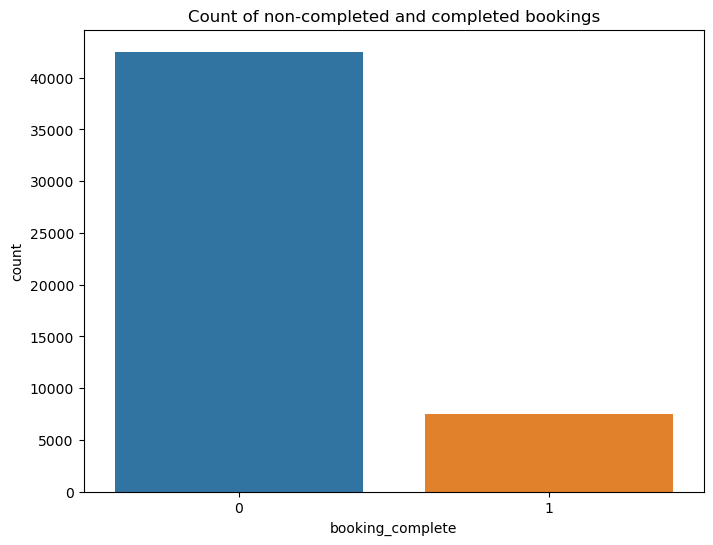

In [17]:
#create barplot
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x="booking_complete", data=df)
plt.title('Count of non-completed and completed bookings')
plt.show()

We are dealing with a classification problem in this case, we want to develop a model that will classify whether a booking will be completed by the customer or not. In the above figure we have a count of all completed and non-completed bookings, completed bookings are represented as 1 and non-completed bookings are represented as 0. When dealing with a classiffication problem we must firstly deal with class imbalance. We can see that class 0 has more data points than class 1, if we train the model on this data the model will be excellent in predicting class 0 more than class 1.

In [18]:
#non complete bookings
(df['booking_complete'] == 0).sum()

42522

In [19]:
#completed bookings
(df['booking_complete'] == 1).sum()

7478

In [20]:
#deal with class imbalance to avoid model bias
zero_entries = df[df['booking_complete'] == 0]

# Randomly select 34,000 entries to remove
entries_to_remove = zero_entries.sample(n=34000, random_state=42)  # Set a random_state for reproducibility

# Remove selected entries from the DataFrame
df_balanced = df.drop(entries_to_remove.index)

In [21]:
#let's check the new df
df_balanced

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,average_cat
2,2,0,0,243,22,17,3,0,36,1,1,0,5.52,0,2.00
9,1,1,0,378,30,12,7,0,36,0,0,0,5.52,0,1.00
10,2,0,0,185,25,14,2,0,100,1,1,1,5.52,0,2.25
12,4,0,0,265,24,19,1,0,61,1,0,1,5.52,0,1.25
16,1,0,0,259,37,6,7,0,36,0,0,0,5.52,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49981,1,0,0,317,6,1,4,719,51,1,0,1,5.00,0,1.25
49984,2,0,0,7,6,4,3,720,4,0,0,0,5.62,1,0.00
49987,3,0,0,243,6,12,5,720,4,1,0,1,5.62,1,1.25
49988,1,0,0,6,6,14,4,720,4,1,1,1,5.62,0,2.25


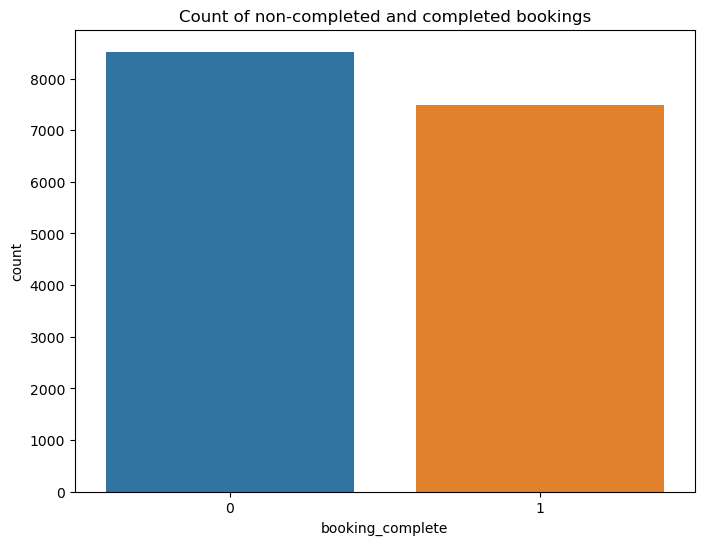

In [22]:
#create barplot
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x="booking_complete", data=df_balanced)
plt.title('Count of non-completed and completed bookings')
plt.show()

## Closely look at Features

Create correlation matrix to find which features are correlated with the target variable, variables with high correlation to the target variable would be important features when we create the model.

In [23]:
#create correlation matrix
correlation_matrix = df.corr(numeric_only = True)
target_correlation = correlation_matrix['booking_complete']

In [24]:
#view the balanced correlation table
target_correlation

num_passengers           0.024116
sales_channel           -0.041060
trip_type               -0.027215
purchase_lead           -0.022131
length_of_stay          -0.042408
flight_hour              0.007127
flight_day              -0.006986
route                   -0.008488
booking_origin           0.130804
wants_extra_baggage      0.068139
wants_preferred_seat     0.050116
wants_in_flight_meals    0.026511
flight_duration         -0.106266
booking_complete         1.000000
average_cat              0.054626
Name: booking_complete, dtype: float64

The correlation between the target variable and the predictor variable before we balance the classes show that the correlation between the target variable and the predictor variables was generally low or close to zero.

In [25]:
#create correlation matrix for the balanced data
correlation_matrix_bal = df_balanced.corr(numeric_only = True)
target_correlation_bal = correlation_matrix_bal['booking_complete']

In [26]:
#view the balanced correlation table
target_correlation_bal

num_passengers           0.036398
sales_channel           -0.065397
trip_type               -0.040413
purchase_lead           -0.020102
length_of_stay          -0.064361
flight_hour              0.012443
flight_day              -0.011796
route                   -0.013398
booking_origin           0.195761
wants_extra_baggage      0.104305
wants_preferred_seat     0.073996
wants_in_flight_meals    0.047922
flight_duration         -0.148235
booking_complete         1.000000
average_cat              0.083423
Name: booking_complete, dtype: float64

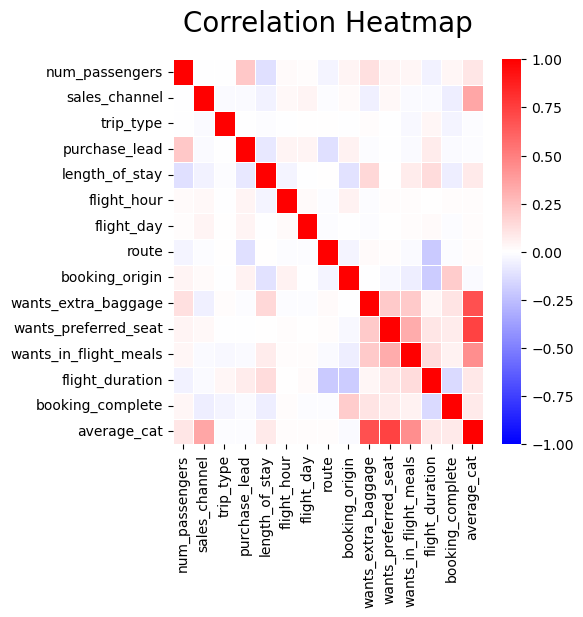

In [27]:
#create a correlation heatmap for the balanced data
plt.figure(figsize=(5, 5))
heatmap = sns.heatmap(df_balanced.corr(numeric_only = True), vmin=-1, vmax=1, linewidths=0.5, cmap = "bwr")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=20);

We inspect the correlation matrix after the class balancing, we can see that the correlation has generally improved. We note also that there are some predictor variables that are not strongly correlated to the target variable which is the `booking_complete`. We can look to removing some of the predictor variable that are less correlated to the target variable. We will first create the model and find important features of the model and using the correlation matrix and the important features to remove features we feel are not contributing to the model.

## Let's develop the model

In [28]:
#create the features and the target variable
col_to_drop2 = ['booking_complete']
X = df_balanced.drop(col_to_drop2, axis=1)
y = df_balanced["booking_complete"]

In [29]:
#let's split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
#create a randomforest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)

# train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
predictions = clf.predict(X_test)

In [31]:
#we want to see the important features
feature_importances = clf.feature_importances_

In [32]:
feature_importances

array([0.04337095, 0.01081134, 0.00189898, 0.16251432, 0.12741089,
       0.12059208, 0.08103966, 0.15091507, 0.15073352, 0.01256626,
       0.01206015, 0.01458417, 0.07979177, 0.03171085])

In [33]:
#we want to see the important features
for feature, importance in zip(range(X.shape[1]), feature_importances):
    print(f"Feature {feature}: {importance}")

Feature 0: 0.0433709503660487
Feature 1: 0.010811337420154533
Feature 2: 0.001898984246532388
Feature 3: 0.1625143240847025
Feature 4: 0.12741088808548645
Feature 5: 0.12059207992538179
Feature 6: 0.08103965931774765
Feature 7: 0.1509150707177384
Feature 8: 0.15073351514562938
Feature 9: 0.012566262738433625
Feature 10: 0.012060146995463188
Feature 11: 0.014584168725545124
Feature 12: 0.07979176645100482
Feature 13: 0.03171084578013146


In [34]:
#let us see the performance of the model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

In [35]:
#print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7
Precision: 0.6692708333333334
Recall: 0.6945945945945946
F1 Score: 0.6816976127320956


We can see from the important features above, there are features that are less  than 3% which would mean they are not contributing much to the model. We would have to remove these features to improve the space the model can take.

### Model without less important features

In [36]:
#let's drop the less important features
col_to_drop2 = ['sales_channel', 'trip_type', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']
df_optimized = df_balanced.drop(col_to_drop2, axis=1)

In [37]:
#create the features and the target variable
col_to_drop_opt = ['booking_complete']
X_opt = df_optimized.drop(col_to_drop_opt, axis=1)
y_opt = df_optimized["booking_complete"]

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# create number of folds
num_folds = 5

# create model
model = RandomForestClassifier(n_estimators=150, max_depth=None, random_state=42)

# create the cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [39]:
# list of metrics to be used
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# metrics to be stored
results = {}

# cross-validation for each metric
for scoring_metric in scoring_metrics:
    scores = cross_val_score(model, X_opt, y_opt, cv=kf, scoring=scoring_metric)
    results[scoring_metric] = scores

# print the results
for scoring_metric, scores in results.items():
    print(f"Cross-Validation {scoring_metric} Scores:", scores)
    print(f"Mean {scoring_metric}:", scores.mean())
    print()

Cross-Validation accuracy Scores: [0.70125   0.7015625 0.7015625 0.6909375 0.688125 ]
Mean accuracy: 0.6966875

Cross-Validation precision Scores: [0.67124183 0.68476128 0.67757009 0.67131474 0.65721649]
Mean precision: 0.6724208882576209

Cross-Validation recall Scores: [0.69391892 0.68881579 0.68258238 0.6717608  0.68640646]
Mean recall: 0.6846968693326076

Cross-Validation f1 Scores: [0.68239203 0.68678255 0.680067   0.6715377  0.6714944 ]
Mean f1: 0.678454735848119

Cross-Validation roc_auc Scores: [0.76927797 0.77170015 0.76704272 0.7614518  0.76218451]
Mean roc_auc: 0.7663314300488693



In [41]:
# list of the average for each metrics
mean_values = [np.mean(results[scoring_metric]) for scoring_metric in scoring_metrics]

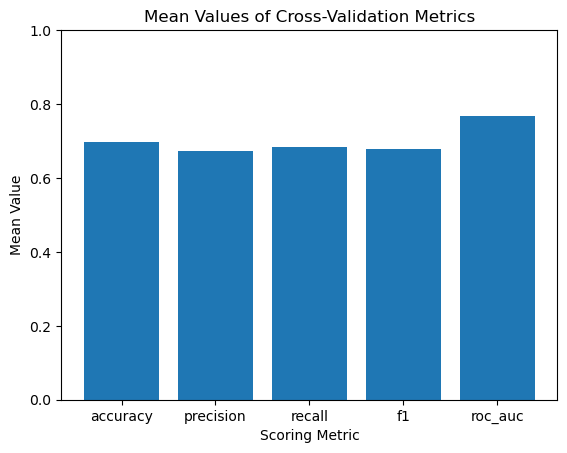

In [42]:
# barplot for each metric
plt.bar(scoring_metrics, mean_values)
plt.xlabel('Scoring Metric')
plt.ylabel('Mean Value')
plt.title('Mean Values of Cross-Validation Metrics')
plt.ylim(0, 1)  # Adjust the y-axis range if needed
plt.show()